In [20]:
# Twits scraping with infinite scroll
import re
from bs4 import BeautifulSoup

import time
import os
import openpyxl

from selenium import webdriver
from selenium.webdriver.firefox.firefox_binary import FirefoxBinary
from itertools import tee, islice, chain

from nltk.corpus import stopwords
from wordcloud import WordCloud



# To control words combination is trying to be able to find previous, current and next words
def previous_and_next(some_iterable):
    prevs, items, nexts = tee(some_iterable, 3)
    prevs = chain([None], prevs)
    nexts = chain(islice(nexts, 1, None), [None])
    return zip(prevs, items, nexts)


def search(myDict, lookup):
    for key, value in myDict.items():
        if lookup.lower() == value.lower():
            return key


# Integer is finding in text to be able to sort descending
def sort_fn(x):
    y = x.find("(")
    z = x.find(")")
    return int(x[y + 1:z])  # After : character rest ist numeric


#  If first character is None, then return ""
def none_str(xt):
    if xt is None:
        return ''
    elif 'http' in re.sub(r'\W+',"",xt):
        return 'URL-Address'
    else:
        return re.sub(r'\W+',"",xt)

In [30]:
#Main and group dictionary tasks
import plotly.graph_objects as go
import pandas as pd

df_main = pd.read_csv("MainDictionary.csv", sep=";", header=None, skiprows=1)
main_dict = {df_main.iloc[i][0]: df_main.iloc[i][1:].tolist() for i in df_main.T}

df_group = pd.read_csv("MainGroup.csv", sep=";", header=None, skiprows=1, index_col=1).to_dict()
group_dict = df_group[0]

In [3]:
#Cleaning main dictionary
def clean_csv(myDict):
    dct = {}
    for key, value in myDict.items():
        lst = []
        for i in value:
            if not pd.isna(i):
                lst += [int(i)]
        dct[key] = lst
    return dct

In [4]:
clean_main_dict = clean_csv(main_dict)

In [5]:
#Searching in group dictionary
def search(myDict, lookup):
    for key, value in myDict.items():
        if lookup == key:
            return value

In [6]:
# Custom iterator to combine words sequentially according to the number given
# ['This', 'is', 'a', 'ball'] --> ['This', 'This is', 'This is a', 'This is a ball']
class MyOwnIterator():
    def __init__(self, iterable, numberOfWords):
        self.iterable = iterable
        self.numberOfWords = numberOfWords
        self.index = -1

    def __iter__(self):
        return self

    def __len__(self):
        return len(self.iterable)

    def __next__(self):
        self.index += 1
        if self.index == len(self.iterable):
            raise StopIteration

        i=0
        tempText = ""
        tempList = []
        while i < self.numberOfWords:
            if tempText != "":
                try:
                    tempText += " " + self.iterable[self.index + i]
                except IndexError:
                    break
            else:
                tempText = self.iterable[self.index + i]

            tempList += [tempText]
            i += 1

        return tempList


In [7]:
#Getting data from Twitter

gecko = os.path.normpath(os.path.join(os.getcwd(), 'geckodriver'))
binary = FirefoxBinary(r'C:\Program Files (x86)\Mozilla Firefox\firefox.exe')
browser = webdriver.Firefox(firefox_binary=binary, executable_path=gecko + '.exe')

browser.get("https://twitter.com/???")
time.sleep(5)

whl_txt = ''

# Page is scrolling n times
for i in range(1, 5):      # n=5
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(3)
    html_source = browser.page_source
    data = html_source.encode('utf-8')

    soup_main = BeautifulSoup(data, 'html.parser')
    article = soup_main.find_all(class_="css-1dbjc4n")
    #('p', {'class': 'css-901oao css-16my406 r-1qd0xha r-ad9z0x r-bcqeeo r-qvutc0'})

for element in article:
    txt_a = ''.join(element.find_all(text=True))  # Getting only texts, other not
    txt_b = re.sub(r'\n+', ' ', txt_a)  # Converting empty paragraph to space character
    txt_b = txt_b[:txt_b.find('pic.twitter.com', 1)]  # Getting text from start until given text in parentheses
    whl_txt += txt_b + '\n' * 2  # Add 2x paragraph

whl_list = list(whl_txt.split())  # Converting to the list

In [9]:
iterativeList = []
for iterator in MyOwnIterator(whl_list,5):
    iterativeList += iterator

In [10]:
#main text from twitter is compared with dictionary

gloss = []
for dicKey, dicValue in clean_main_dict.items():

    for i in iterativeList:

        if dicKey == i.lower():

            for valueItem in dicValue:
                lookup = valueItem

                if search(group_dict, lookup):
                    gloss += [search(group_dict, lookup)]


In [28]:
#Collected words from Twitter and their repetition number 
import collections

UniqList = []
Sum_List = ''

# Cleaning "whl_list" from non-alphabetic characters
clean_whl_list = [re.sub('[^a-zA-Z0-9]+', '', _) for _ in whl_list if not re.findall('[#@(http)]+', _)]

# All words convert lower case to be able to get best result
clean_whole_list = map(str.lower,clean_whl_list)

# Set Stopwords. In Python, searching a set is much faster than searching
# a list, so convert the stop words to a set  
stops = set(stopwords.words("english"))   
  
# Remove stop words  
meaningful_words = [w.strip().lower() for w in clean_whole_list if not w in stops and len(w.strip())>2 and w !='' and ('abc' not in w)]           #returns a list


def tab(tx,num):
    nTex = ''
    nIdx = len(tx)
    
    if (nIdx + 1) > 0 and (nIdx + 1) <= 8:
        nTex = tx + "\t"*4 + "(" + str(num) + ")\n"
    elif (nIdx + 1) > 8 and (nIdx + 1) <= 16:
        nTex = tx + "\t"*3 + "(" + str(num) + ")\n"
    elif (nIdx + 1) > 16 and (nIdx + 1) <= 24:
        nTex = tx + "\t"*2 + "(" + str(num) + ")\n"
    else:
        nTex = tx + "\t" + "(" + str(num) + ")\n"
    return nTex

meaningful_words_list = sorted(collections.Counter(meaningful_words).items(), key=lambda pair: pair[1], reverse=True)

# for i in meaningful_words:
#     if (none_str(i).lower() + "(" + str(meaningful_words.count(i)) + ")") not in UniqList:
#         UniqList += [none_str(i).lower() + "(" + str(meaningful_words.count(i)) + ")"]

# srtList = sorted(UniqList, key=sort_fn, reverse=True)
text_container = ''
for txt, val in meaningful_words_list:
    if val >=30:                        # listed more than 1000 repetition
        text_container += tab(txt,val)
        
print(text_container) # Most common scraped words

available			(300)
february			(190)
originals			(184)
boost				(175)
350				(125)
one				(100)
yeezy				(85)
march				(75)
america				(75)
select				(75)
retailers			(75)
exclusively			(75)
north				(50)
700				(50)
mnvn				(50)
game				(50)
alone				(50)
new				(46)
2020				(40)
globally			(33)



In [23]:
#Producing value for x axis and y axis for graphic
def axis_value(textPart):
    grItem = []
    numm = []

    for glossItem in gloss:
        if textPart in glossItem:
            num = gloss.count(glossItem)
            if glossItem not in grItem:
                grItem += [glossItem]
                numm += [num]
    return grItem, numm

<function matplotlib.pyplot.show(*args, **kw)>

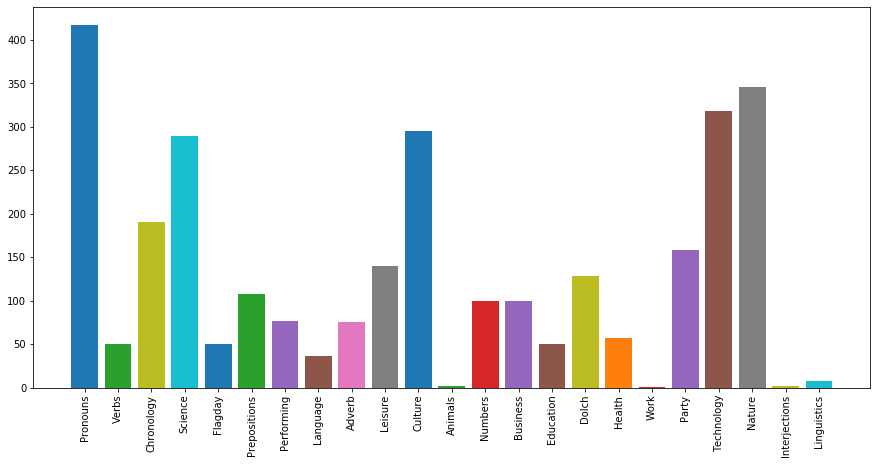

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
# ax1, ax2 = axes

x_Pronouns, y_Pronouns = axis_value('Pronouns')
x_Visual_Sound, y_Visual_Sound = axis_value('Visual_Sound')
x_Verbs, y_Verbs = axis_value('Verbs')
x_Clothes_and_fashion, y_Clothes_and_fashion = axis_value('Clothes_and_fashion')
x_Family_and_life_stages, y_Family_and_life_stages = axis_value('Family_and_life_stages')
x_Personality_and_emotions, y_Personality_and_emotions = axis_value('Personality_and_emotions')
x_Crime_and_law, y_Crime_and_law = axis_value('Crime_and_law')
x_Letters_Punctuation, y_Letters_Punctuation = axis_value('Letters_Punctuation')
x_Chronology, y_Chronology = axis_value('Chronology')
x_Science, y_Science = axis_value('Science')
x_Flagday, y_Flagday = axis_value('Flagday')
x_Religion_and_politics, y_Religion_and_politics = axis_value('Religion_and_politics')
x_Prepositions, y_Prepositions = axis_value('Prepositions')
x_Body_and_appearance, y_Body_and_appearance = axis_value('Body_and_appearance')
x_Performing, y_Performing = axis_value('Performing')
x_Language, y_Language = axis_value('Language')
x_Adverb, y_Adverb = axis_value('Adverb')
x_Leisure, y_Leisure = axis_value('Leisure')
x_Travel_and_tourism, y_Travel_and_tourism = axis_value('Travel_and_tourism')
x_Time, y_Time = axis_value('Time')
x_Adjective, y_Adjective = axis_value('Adjective')
x_Culture, y_Culture = axis_value('Culture')
x_Application, y_Application = axis_value('Application')
x_Animals, y_Animals = axis_value('Animals')
x_Numbers, y_Numbers = axis_value('Numbers')
x_Business, y_Business = axis_value('Business')
x_Education, y_Education = axis_value('Education')
x_Occupations, y_Occupations = axis_value('Occupations')
x_Social_issues, y_Social_issues = axis_value('Social_issues')
x_Dolch, y_Dolch = axis_value('Dolch')
x_Temperature, y_Temperature = axis_value('Temperature')
x_The_media, y_The_media = axis_value('The_media')
x_Health, y_Health = axis_value('Health')
x_Welfare, y_Welfare = axis_value('Welfare')
x_Work, y_Work = axis_value('Work')
x_Party, y_Party = axis_value('Party')
x_Technology, y_Technology = axis_value('Technology')
x_Houses_and_buildings, y_Houses_and_buildings = axis_value('Houses_and_buildings')
x_Nature, y_Nature = axis_value('Nature')
x_Interjections, y_Interjections = axis_value('Interjections')
x_Linguistics, y_Linguistics = axis_value('Linguistics')




axes.bar(x_Pronouns, y_Pronouns)
axes.bar(x_Visual_Sound, y_Visual_Sound)
axes.bar(x_Verbs, y_Verbs)
axes.bar(x_Clothes_and_fashion, y_Clothes_and_fashion)
axes.bar(x_Family_and_life_stages, y_Family_and_life_stages)
axes.bar(x_Personality_and_emotions, y_Personality_and_emotions)
axes.bar(x_Crime_and_law, y_Crime_and_law)
axes.bar(x_Letters_Punctuation, y_Letters_Punctuation)
axes.bar(x_Chronology, y_Chronology)
axes.bar(x_Science, y_Science)
axes.bar(x_Flagday, y_Flagday)
axes.bar(x_Religion_and_politics, y_Religion_and_politics)
axes.bar(x_Prepositions, y_Prepositions)
axes.bar(x_Body_and_appearance, y_Body_and_appearance)
axes.bar(x_Performing, y_Performing)
axes.bar(x_Language, y_Language)
axes.bar(x_Adverb, y_Adverb)
axes.bar(x_Leisure, y_Leisure)
axes.bar(x_Travel_and_tourism, y_Travel_and_tourism)
axes.bar(x_Adjective, y_Adjective)
axes.bar(x_Culture, y_Culture)
axes.bar(x_Application, y_Application)
axes.bar(x_Animals, y_Animals)
axes.bar(x_Numbers, y_Numbers)
axes.bar(x_Business, y_Business)
axes.bar(x_Education, y_Education)
axes.bar(x_Occupations, y_Occupations)
axes.bar(x_Social_issues, y_Social_issues)
axes.bar(x_Dolch, y_Dolch)
axes.bar(x_Temperature, y_Temperature)
axes.bar(x_The_media, y_The_media)
axes.bar(x_Health, y_Health)
axes.bar(x_Welfare, y_Welfare)
axes.bar(x_Work, y_Work)
axes.bar(x_Party, y_Party)
axes.bar(x_Technology, y_Technology)
axes.bar(x_Houses_and_buildings, y_Houses_and_buildings)
axes.bar(x_Nature, y_Nature)
axes.bar(x_Interjections, y_Interjections)
axes.bar(x_Linguistics, y_Linguistics)



axes.tick_params(axis='x', labelrotation=90)

plt.show

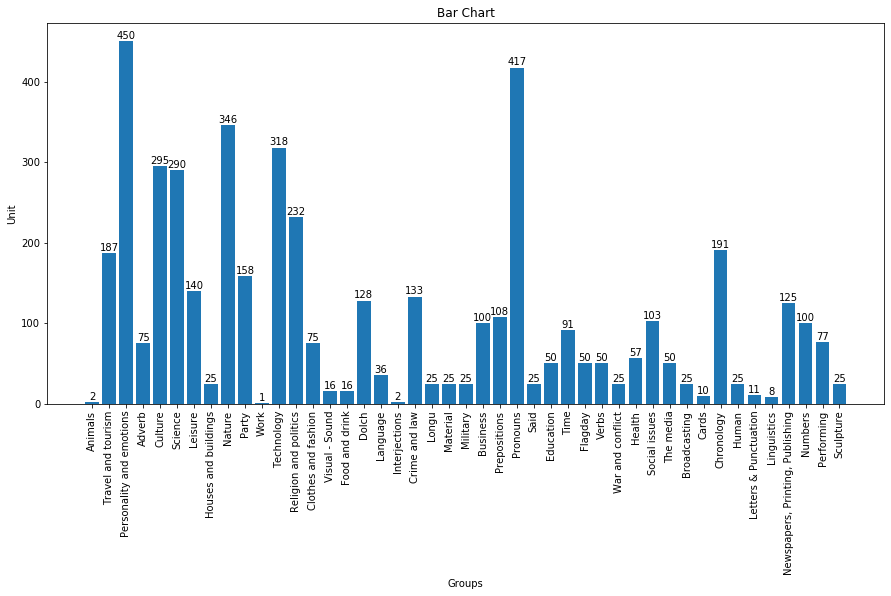

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,7))

graphic_axes = []
graphic_values = []

for val in group_dict.values():
    x,y = axis_value(val)
    graphic_axes += x
    graphic_values += y

# Plot the bar graph
plot = plt.bar(graphic_axes, graphic_values)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom')
 
# Add labels and title
plt.title("Bar Chart")
plt.xlabel("Groups")
plt.ylabel("Unit")
axes.tick_params(axis='x', labelrotation=90)
 
# Display the graph on the screen
plt.show()

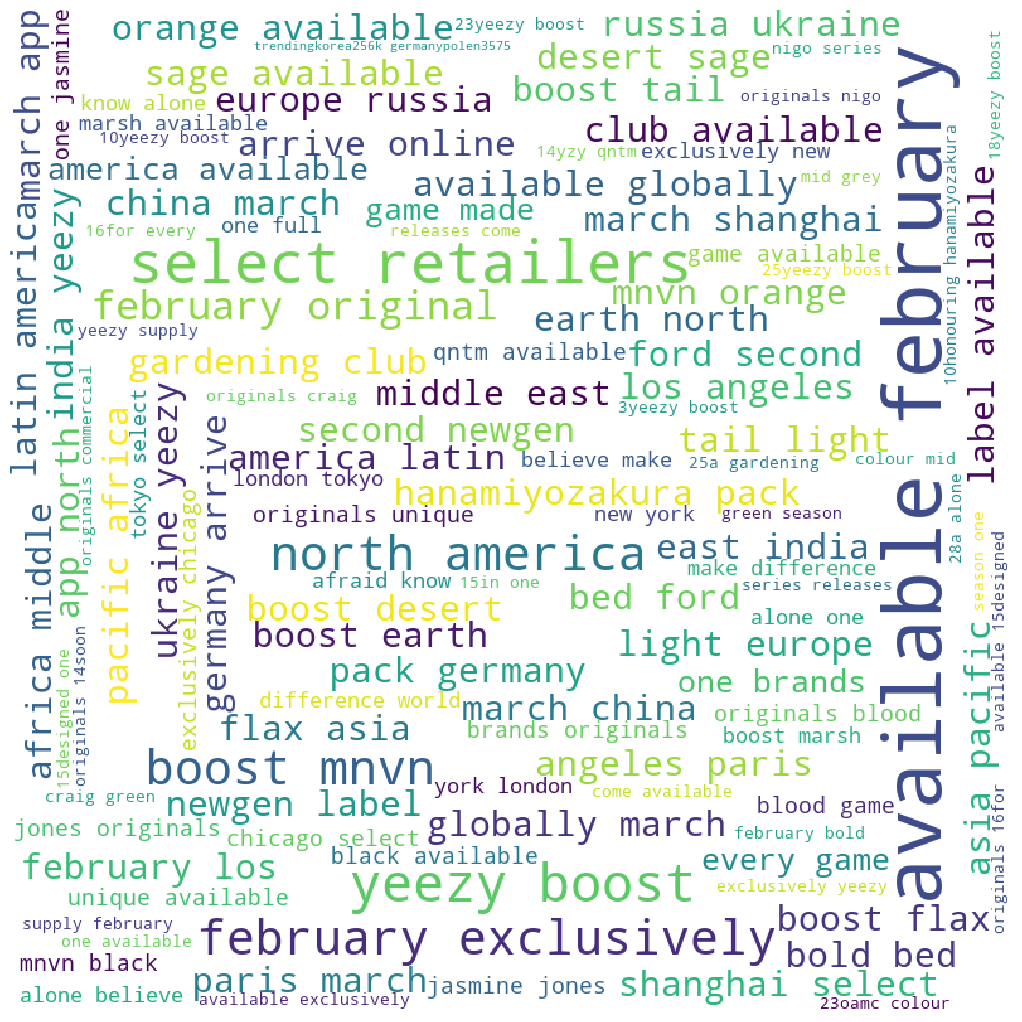

In [27]:
# Graphic from vice words
words_text = ' '.join(meaningful_words)

wordcloud_words = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            min_font_size = 10).generate(words_text) 


# plot the WordCloud image                        
plt.figure(figsize = (14, 14), facecolor = None) 
plt.imshow(wordcloud_words) 
plt.axis("off") 
plt.tight_layout(pad = 0)
# plt.title('WORDS WORDCLOUD')
  
# plt.show()
plt.savefig("Word Cloud", dpi=300)